<a href="https://colab.research.google.com/github/Haimoshri/Kaggle-Titanic/blob/master/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

In [0]:
dict_train = dict()
with open('train.csv') as f:
  """
  'PassengerId' = 0
  'Survived' = 1
  'Pclass' = 2
  'Sex' = 4
  'Age' = 5
  'SibSp' = 6
  'Parch' = 7
  """
  file = csv.reader(f, delimiter = ",")
  count = 0
  for line in file:
    if count == 0:
      count += 1
      continue
    else:
      dict_train[count] = dict()
      dict_train[count]['PassengerId'] = line[0]
      dict_train[count]['Survived'] = line[1]
      dict_train[count]['Pclass'] = line[2]
      dict_train[count]['Sex'] = line[4]
      dict_train[count]['Age'] = line[5]
      dict_train[count]['SibSp'] = line[6]
      dict_train[count]['Parch'] = line[7]
      count += 1

In [0]:
def combine(row):
  if row['Age'] > 35 and row['Sex'] == 'female':
    return 1
  else:
    return 0


In [0]:
train['Age_Sex'] = train.apply (lambda row: combine(row), axis=1)
test['Age_Sex'] = test.apply (lambda row: combine(row), axis=1)

In [0]:
change = ['Age']
train[change] = train[change].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
test[change] = test[change].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


In [0]:
train['Age'].fillna((train['Age'].mean()), inplace=True)
test['Age'].fillna((test['Age'].mean()), inplace=True)

In [0]:
train = train.replace(['male', 'female'], [0,1])
test = test.replace(['male', 'female'], [0,1])

In [0]:
X = train[['Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Age_Sex']]
X_test = test[['Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Age_Sex']]

In [0]:
Y = train['Survived']

In [0]:
X.index = train['PassengerId']
X_test.index = test['PassengerId']

In [0]:
Y.index = train['PassengerId']

In [0]:
class MyModel(nn.Module):
  def __init__(self, input_size, output_size, hidden_size):
    super(MyModel, self).__init__()
    self.layer1 = nn.Linear(input_size, hidden_size, True)
    self.activation1 = nn.ReLU()
    self.layer2 = nn.Linear(hidden_size, output_size, True)
    self.activation2 = nn.Sigmoid()
  
  def forward(self, x):
    output1 = self.layer1(x)
    activated_output1 = self.activation1(output1)
    output2 = self.layer2(activated_output1)
    output = self.activation2(output2)
    return output

In [123]:
hidden_size = 32
input_size = 6 #change hardcoding
output_size = 1
epochs = 30
lr = 0.01
loss_fn = nn.BCELoss()

classifier = MyModel(input_size, output_size, hidden_size)
#optimizer = optim.SGD(classifier.parameters(), lr = lr, momentum=0.9)
optimizer = optim.Adam(classifier.parameters(), lr = lr)

classifier = classifier.to(device)
classifier.train()

for epoch in range(epochs):
  classifier.train()
  total_loss = 0

  for index, row in X.iterrows():
    x = torch.Tensor([row['Age'], row['Pclass'], row['Sex'], row['SibSp'], row['Parch'], row['Age_Sex']])
    y = torch.Tensor([Y.loc[index]])

    classifier.zero_grad()
    logits = classifier.forward(x)
    loss = loss_fn(logits, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    total_loss += loss.item()
  if (epoch%10 == 0):
    print (total_loss/len(X))


  

0.5117059136363526
0.44022939092704116
0.43013842525035845


In [0]:
classifier.eval()
correct = 0

Y_pred = []

for index, row in X_test.iterrows():
    x = torch.Tensor([row['Age'], row['Pclass'], row['Sex'], row['SibSp'], row['Parch'], row['Age_Sex']])
    y_pred = classifier.forward(x)
    Y_pred.append(int(y_pred.round().tolist()[0]))

In [0]:
submit = pd.DataFrame({'Survived':Y_pred})
submit.index = test['PassengerId']
submit.to_csv('submission1.csv', header = True)

In [111]:
submit.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [0]:
X2 = train[['Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Survived']]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf162f9ba8>,
      dtype=object)

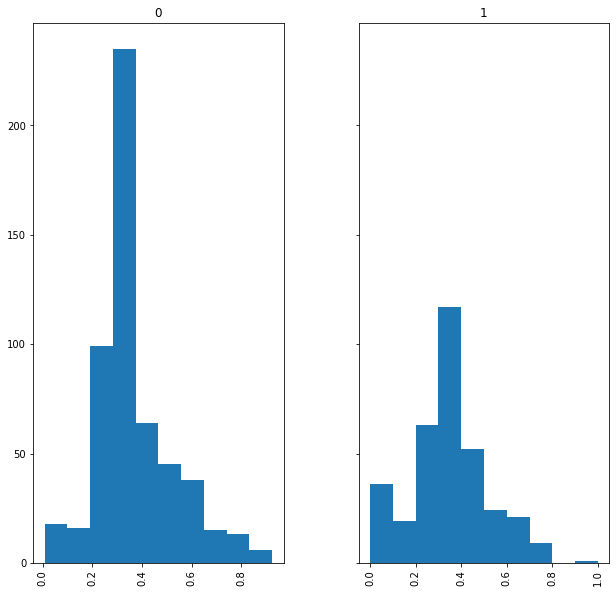

In [113]:
X2.hist(column = 'Age', by='Survived', sharey = True, figsize=(10,10))

#X2.loc[(X2.Survived == 0), ['Age']].plot.hist(color = 'c')
#X2.loc[(X2.Survived == 1), ['Age']].plot.hist(color = 'm')


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf1699b198>,
      dtype=object)

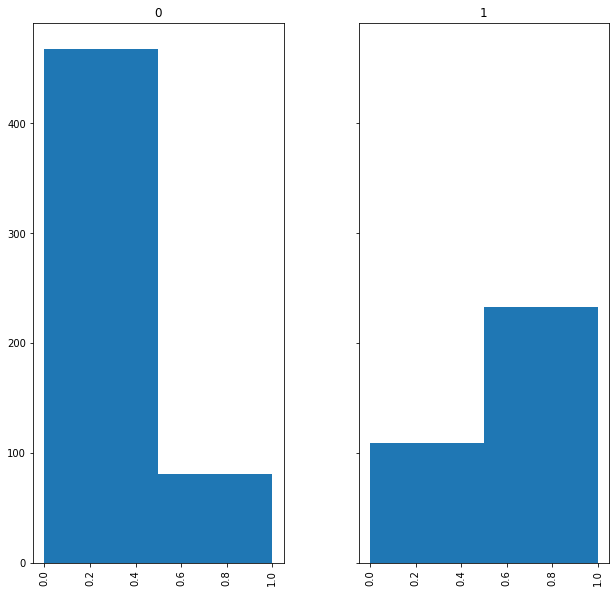

In [114]:
X2.hist(column = 'Sex',by='Survived', sharey = True, figsize=(10,10), bins=2)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf19e8a390>,
      dtype=object)

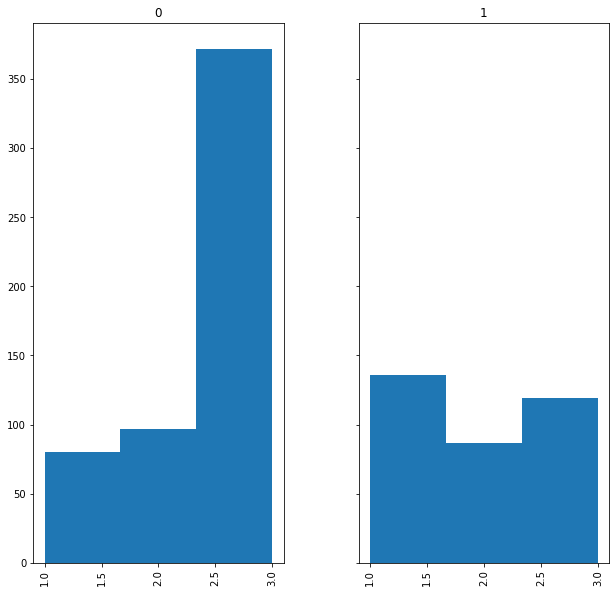

In [115]:
X2.hist(column = 'Pclass',by='Survived', sharey = True, figsize=(10,10), bins=3)

array([0, 1, 2, 5, 3, 4, 6])

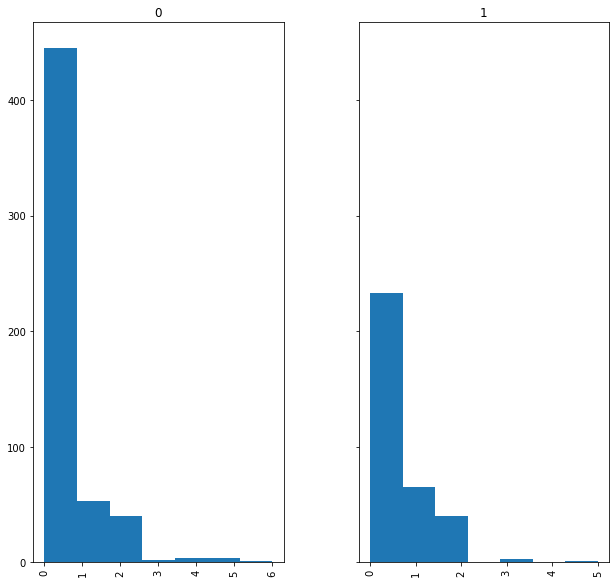

In [116]:
X2.hist(column = 'Parch',by='Survived', sharey = True, figsize=(10,10), bins = 7)
X2['Parch'].unique()